# Testing Functionality

The ``satrain`` package provides built-in testing functionality for making the retrieval evaluation easy and reproducible. The testing data of the SatRain dataset has been kept in the original collocation scenes that have irregular sizes. While irregular-sized input data is uncommon in most traditional machine-learning applications, they are a practical reality for most satellite retrievals. The original observation structure of the testing data was retained to make it easier to evaluate existing retrieval algorithms on the data. Morever, evaluating all retrievals against the gridded precipitation reference also ensures that retrievals operating on the on-swath and gridded geometries can be compared directly.
To simplify running most retrievals on the testing data, the ``satrain.evaluation`` module provides functionality to batch and tile the input data and reconstructing the retrieval results.

## The ``Evaluator`` class

All evaluation functionality provided by the ``satrain`` package is implemented by the ``satrain.evaluation.Evaluator`` class. To use the ``Evaluator`` class to evaluate a retrieval, the user only needs to provide is an interface function to their retrieval. The evaluator class  will then automatically load the input data and track the accuracy of the resulting retrieval results. 

This documentation illustrates how the evaluator loads the input data in different formats and demonstrate how the evaluator can be used to evaluate retrievals.

We start by instantiating an evaluator object that will load gridded GMI observations and the ``total_precipitation`` field from the ancillary data over the CONUS domain.

In [2]:
%load_ext autoreload
%autoreload 2
from satrain.evaluation import Evaluator
evaluator = Evaluator(
    base_sensor="gmi",
    geometry="gridded",
    retrieval_input=["gmi", {"name": "ancillary", "variables": ["total_precipitation"]}],
    domain="conus"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Input Data

The evaluator loads the retrieval input data for all testing scenes over the chosen domain. Below is an example of the data loaded by the evaluator.

In [3]:
input_data = evaluator.get_input_data(scene_index=0)
input_data

<xarray.Dataset> Size: 167MB
Dimensions:    (latitude: 890, longitude: 854, features_gmi: 13,
                features_ancillary: 1)
Coordinates:
  * latitude   (latitude) float64 7kB 52.0 51.97 51.93 ... 19.74 19.7 19.66
  * longitude  (longitude) float64 7kB -91.98 -91.95 -91.91 ... -60.99 -60.95
Dimensions without coordinates: features_gmi, features_ancillary
Data variables:
    time       (latitude, longitude) datetime64[ns] 6MB 2022-01-01T02:26:00 ....
    obs_gmi    (features_gmi, latitude, longitude) float64 79MB nan nan ... nan
    eia_gmi    (features_gmi, latitude, longitude) float64 79MB nan nan ... nan
    ancillary  (features_ancillary, latitude, longitude) float32 3MB 1.539e-0...
Attributes:
    satellite:       GPM
    sensor:          GMI
    preprocessor:    2412c
    scan_start:      853
    scan_end:        1270
    gpm_input_file:  1C-R.GPM.GMI.XCAL2016-C.20220101-S015403-E032636.044560....
    lower_left_row:  145
    lower_left_col:  293

The data loaded by the evaluator are the retrieval input data from the first (``scene_index=0``) scene in the CONUS testing dataset. The data is in the gridded geometry with 890 latitude points and 854 longitude points. The loaded dataset contains the GMI observations (``obs_gmi``), the GMI earth-incidence angles (``eia_gmi``) and the total precipitation in the ``ancillary`` variable. 

We can use the loaded dataset to visualize the GMI observations in the input data. Since the loaded data is in the gridded format, the GMI observations only partially cover the scene.

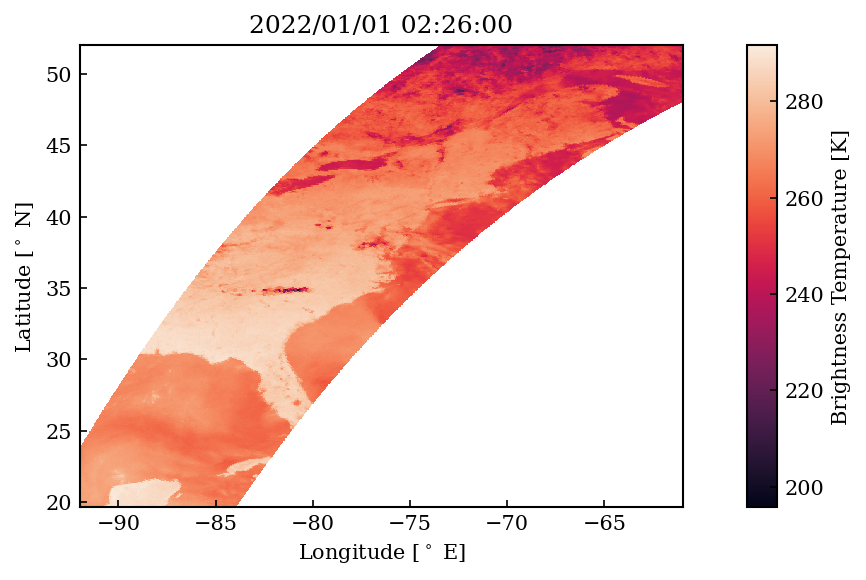

In [6]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from satrain.plotting import set_style, cmap_tbs
set_style()
fig = plt.figure(figsize=(6, 4))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.05])
ax = fig.add_subplot(gs[0, 0])

lons = input_data.longitude.data
lats = input_data.latitude.data
tbs = input_data.obs_gmi.data[7] # GMI 89-GHz, H channel.
mappable = ax.pcolormesh(lons, lats, tbs, cmap=cmap_tbs)
ax.set_xlabel(r"Longitude [$^\circ$ E]")
ax.set_ylabel(r"Latitude [$^\circ$ N]")

time = input_data.time.data
median_time = np.median(time[np.isfinite(time)].astype("uint64")).astype(time.dtype)
date = median_time.astype("datetime64[s]").item()
ax.set_title(date.strftime("%Y/%m/%d %H:%M:%S"), loc="center")

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(mappable, label="Brightness Temperature [K]", cax=cax)

### Tiling the Input Data

Since many image-based ML models require a the input data to have a fixed size, the evaluator also provides functionality to tile and batch the input. In this case, the ``get_input_data`` function returns an iterator over the tiled observations. We verify below that the loaded data has the desired tile size.

In [24]:
input_data = evaluator.get_input_data(0, tile_size=(256, 256), batch_size=2)
tiles = list(iter(input_data))
tiles[0]

<xarray.Dataset> Size: 29MB
Dimensions:    (batch: 2, latitude: 256, longitude: 256, features_gmi: 13,
                features_ancillary: 1)
Coordinates:
    longitude  (batch, longitude) float64 4kB -85.0 -84.96 ... -68.77 -68.74
    latitude   (latitude) float64 2kB 45.02 44.98 44.95 ... 35.81 35.78 35.74
Dimensions without coordinates: batch, features_gmi, features_ancillary
Data variables:
    time       (batch, latitude, longitude) datetime64[ns] 1MB 2022-01-01T02:...
    obs_gmi    (batch, features_gmi, latitude, longitude) float64 14MB nan .....
    eia_gmi    (batch, features_gmi, latitude, longitude) float64 14MB nan .....
    ancillary  (batch, features_ancillary, latitude, longitude) float32 524kB ...
Attributes:
    satellite:       GPM
    sensor:          GMI
    preprocessor:    2412c
    scan_start:      853
    scan_end:        1270
    gpm_input_file:  1C-R.GPM.GMI.XCAL2016-C.20220101-S015403-E032636.044560....
    lower_left_row:  145
    lower_left_col:  293

Plotting one of the resulting tiles, we see that they correspond to a subset of the full testing scene displayed above.

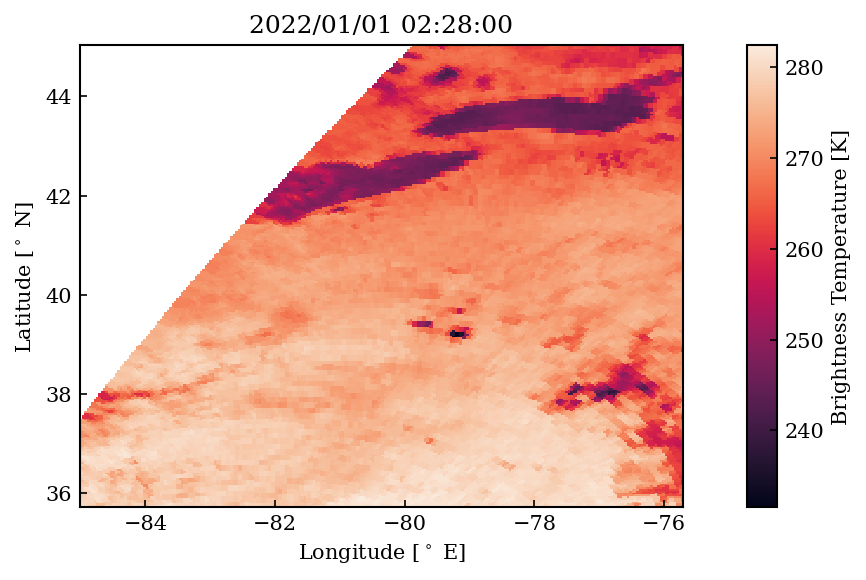

In [25]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from satrain.plotting import set_style, cmap_tbs
set_style()
fig = plt.figure(figsize=(6, 4))
gs = GridSpec(1, 2, width_ratios=[1.0, 0.05])
ax = fig.add_subplot(gs[0, 0])

lons = tiles[3].longitude.data[0]
lats = tiles[3].latitude.data
tbs = tiles[3].obs_gmi.data[0, 7] # GMI 89-GHz, H channel.
mappable = ax.pcolormesh(lons, lats, tbs, cmap=cmap_tbs)
ax.set_xlabel(r"Longitude [$^\circ$ E]")
ax.set_ylabel(r"Latitude [$^\circ$ N]")

time = tiles[3].time.data
median_time = np.median(time[np.isfinite(time)].astype("uint64")).astype(time.dtype)
date = median_time.astype("datetime64[s]").item()
ax.set_title(date.strftime("%Y/%m/%d %H:%M:%S"), loc="center")

cax = fig.add_subplot(gs[:, -1])
plt.colorbar(mappable, label="Brightness Temperature [K]", cax=cax)

## Loading Tabular Data

Pixel-based retrieval algorithms typically discard the spatial structure of the input and operate on tabular data treating the pixels as a 1D sequence. The evaluator also provides functionality to load the data in tabular format.

In [42]:
data_tabular = evaluator.get_input_data(0, format="tabular", batch_size=None)
data_tabular

<xarray.Dataset> Size: 185MB
Dimensions:    (batch: 760060, features_gmi: 13, features_ancillary: 1)
Coordinates:
  * batch      (batch) object 6MB MultiIndex
  * latitude   (batch) float64 6MB 52.0 52.0 52.0 52.0 ... 19.66 19.66 19.66
  * longitude  (batch) float64 6MB -91.98 -91.95 -91.91 ... -61.02 -60.99 -60.95
Dimensions without coordinates: features_gmi, features_ancillary
Data variables:
    time       (batch) datetime64[ns] 6MB 2022-01-01T02:26:00 ... NaT
    obs_gmi    (features_gmi, batch) float64 79MB nan nan nan ... nan nan nan
    eia_gmi    (features_gmi, batch) float64 79MB nan nan nan ... nan nan nan
    ancillary  (features_ancillary, batch) float32 3MB 1.539e-06 ... nan
Attributes:
    satellite:       GPM
    sensor:          GMI
    preprocessor:    2412c
    scan_start:      853
    scan_end:        1270
    gpm_input_file:  1C-R.GPM.GMI.XCAL2016-C.20220101-S015403-E032636.044560....
    lower_left_row:  145
    lower_left_col:  293

## Evaluating Precipitation Retrievals

Above we have seen how the evaluator can be used to load the testing data in different formats. However, it is generally
not necessary to use these function directly to evaluate a retrieval. Instead, the evaluator will take care of the data
loading and evaluating the retrieval results in one go. All we need to do for this is write an interface function
that runs the retrieval on the input data loaded by the evaluator.

Below we define a very simple retrieval function, which simply returns the ERA5 total precipitation from the input data but renames it to the ``surface_precip`` variable expected by the evaluator.


In [60]:
import xarray as xr

def retrieval_fn(input_data: xr.Dataset) -> xr.Dataset:
    """
    Retrieval interface function returning the total precipitation from the ancillary data.

    Args:
        input_data: A xr.Dataset containing input data loaded by the evaluator.

    Return:
        A xr.Dataset containing the 'surface_precip'.
    """
    print(f"Input data shape: ({input_data["ancillary"].shape})")
    return xr.Dataset({
        "surface_precip": 1e3 * input_data.ancillary[{"features_ancillary": 0}] # Remove feature dimension and convert to mm/h.
    })

Once we have the ``retrieval_fn`` interface function defined, we can use it to visualize the retrieval results. Note that the ``retrieval_fn`` defined above works with any possible input data format since it simply returns the ER5 precipitation from the input data. Note that depending on whether the input is tiled, or batched, or both, the function may be called multiple times.

Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((2, 1, 256, 256))
Input data shape: ((1, 1, 256, 256))


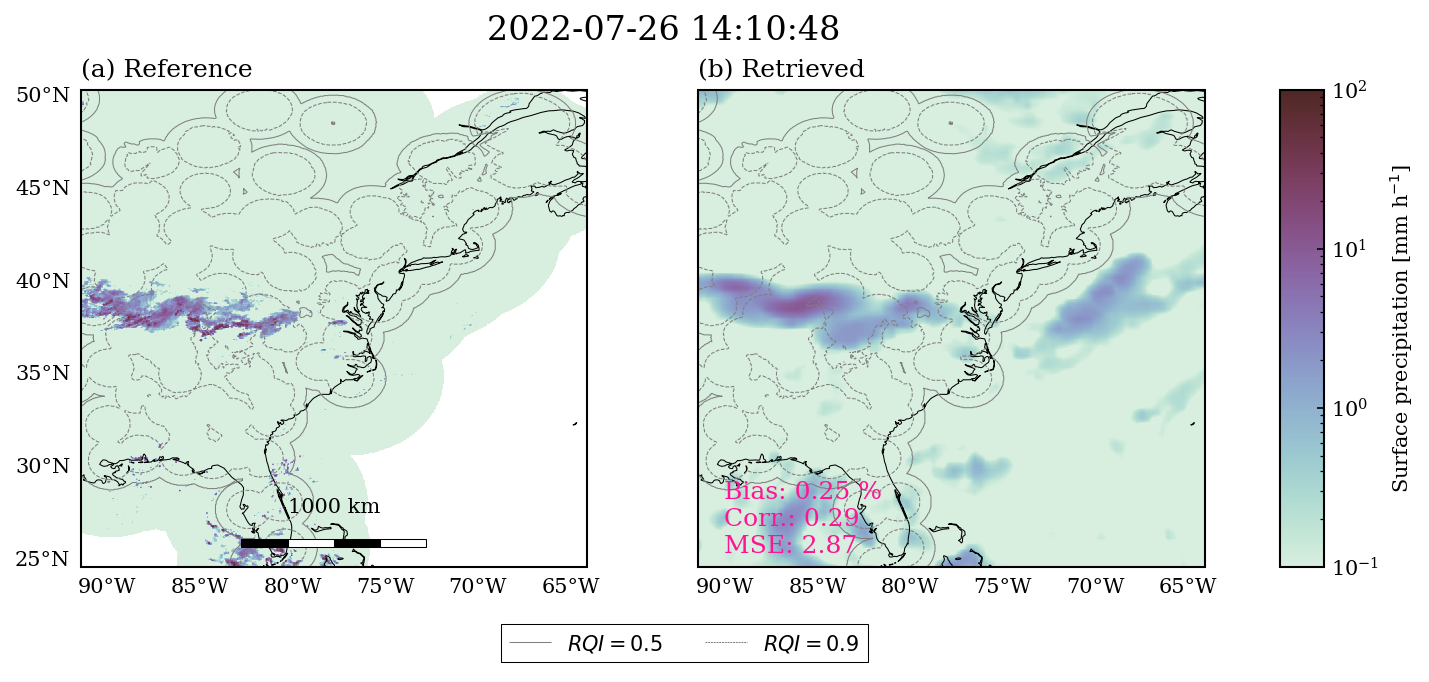

In [62]:
evaluator.plot_retrieval_results(
    1637,
    retrieval_fn=retrieval_fn,
    input_data_format="spatial",
    tile_size=(256, 256),
    batch_size=2,
    include_metrics=True
);

## Result format

For the evaluator to be able to evaluate the retrieval, the results returned by the interface function must adhere to the expected data format. The evaluator expects an ``xarray.Dataset`` with the same dimensions as the provided input data (except for the feature dimensions). The table below lists the expected variables. 

> **Note:** that the retrieval can provide any subset of them as they will be evaluated independently.

|                         Task | Variable name             | Meaning                                       | Data type | Value range
|------------------------------|---------------------------|-----------------------------------------------|----------------|---|
| Precipitation Quantification | ``surface_precip``        | The surface precipitation rate in mm h$^{-1}$ | floating point |  $0 \leq$ |
| Prob. Precipitation Detection | ``probability_of_precip`` | Estimated probability of observing a raining pixel | floating point | [0, 1] |
| Precipitation Detection | ``precip_flag`` | Flag indicating whether a pixel is predicted to be raining or not | bool | {``True``,``False``} |
| Prob. Heavy Precipitation Detection | ``probability_of_heavy_precip`` | Estimated probability of observing heavy precipitation (RR > 10 mm $h^{-1}$) | floating point | [0, 1] |
| Heavy Precipitation Detection | ``heavy_precip_flag`` | Flag indicating whether a pixel is predicted to contain heavy precipitation| bool | {``True``,``False``} |

### Metrics

The evaluator keeps track of the accuracy of separate metrics for each of the five tasks that the retrieval is evaluated on. If the target variable is not present in the retrieval results that accuracy of these results is not tracked. 

#### Precipitation quantification

By default, the quantitative precipitation estimates returned by the retrieval callback function (``surface_precip``) are evaluated using the following metrics.
 
 1. Bias
 2. The mean absolute error (MAE)
 3. the mean squared error (MSE)
 4. The mean absolute percentage error (SMAPE) for precipitation rates exceedin 0.1 mm h$^{-1}$.
 5. The linear correlation coefficient
 6. The spectral coeherence from which the effective resolution is computed

#### Precipitation detection

By default, the deterministic precipitation detection (``precip_flag``) and deterministic heavy precipitation (``heavy_precip_flag``) estimates returned by the retrieval callback function are evaluated using the following metrics.

 1. POD
 2. FAR
 2. Heidke Skill Score (HSS)

#### Probabilistic precipitation detection

The probabilistic precipitation detection (``precip_flag``) and probabilistic heavy precipitation (``heavy_precip_flag``) estimates returned by the retrieval callback function are evaluated using the following metrics.

 1. Precision-recall curve (PR curve)


## Running the Evaluation

Evaluating the retrieval on the full testing dataset is then as easy as calling the ``evaluator.evaluate`` function. Below, we run it on the Austria domain as it is the smallest testing dataset. We also redefine the interface function to not print the input data shape on every invocation.

> **Note**: The evaluator support running the evaluation in parallel using multiple processes via the ``n_processes`` keyword argument. However, this requires the retrieval function to be pickleable and safe for multiprocessing and thus may not work with any ``retrieval_fn``.

In [65]:
def retrieval_fn(input_data: xr.Dataset) -> xr.Dataset:
    """
    Retrieval interface function returning the total precipitation from the ancillary data.

    Args:
        input_data: A xr.Dataset containing input data loaded by the evaluator.

    Return:
        A xr.Dataset containing the 'surface_precip'.
    """
    return xr.Dataset({
        "surface_precip": 1e3 * input_data.ancillary[{"features_ancillary": 0}] # Remove feature dimension and convert to mm/h.
    })
    
evaluator = Evaluator(
    base_sensor="gmi",
    geometry="gridded",
    retrieval_input=["gmi", {"name": "ancillary", "variables": ["total_precipitation"]}],
    domain="austria"
)
evaluator.evaluate(retrieval_fn=retrieval_fn);

Output()

## Displaying the Results

After the evaluation has been run, the results can be accessed using corresponding getter functions. The results are returned as ``pandas.DataFrame`` that displays nicely in the notebook environment.

In [69]:
evaluator.get_precip_quantification_results(name="Test retrieval")

/home/simon/src/satrain/src/satrain/baselines.py:61: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'scales' ('scales',) The recommendation is to set join explicitly for this case.
  results = xr.concat(results, dim="algorithm")


,Bias [$\%$],MAE [$mm h^{-1}$],MSE [$(mm h^{-1})^2$],SMAPE$_{0.1}$ [$\%$],Correlation coeff. [],Effective resolution [$^\circ$]
Test retrieval,76.231029,0.112298,0.265545,137.783548,0.315425,inf
ERA5,27.824237,0.113220,0.173934,141.840027,0.458022,inf
GPROF V7 (GMI),27.085501,0.112640,0.211739,96.359131,0.782981,inf
